<a href="https://colab.research.google.com/github/bkvkrll/Introduction-to-Neural-Networks/blob/main/lesson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшении работы нейронной сети. Обучите на выбор:

*VAE на fashion_mnist

*GAN на одном классе CIFAR

*классификатор на данных tfds (Kaggle, UCI)

*семантическую сегментацию на данных tfds (Kaggle, UCI).

Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# Построение кастомного слоя
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a unit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # двуа параметра на входе
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1] # размер нашего пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # добавление шума
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # восстанавление пакета единиц информации, опираясь на параметры распределения

In [3]:
latent_dim = 2 # берем пространство равное 2 для быстроты

encoder_inputs = keras.Input(shape=(28, 28, 1))
# построение сверточной модели
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# построение выходов
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
# размерность 7 * 7 * 64 
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14x14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 28x28
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
# создаем модель как наследник класса Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data): 
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # создание объекта для дифферецнирования
            z_mean, z_log_var, z = encoder(data)  
            reconstruction = decoder(z) 
     
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
  
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() # подгрузка FASHION-MNIST
mnist_units = np.concatenate([x_train, x_test], axis=0)
mnist_units = np.expand_dims(mnist_units, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # задание оптимайзера
vae.fit(mnist_units, epochs=30, batch_size=128) # проведение обучения

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 120s 215ms/step - loss: 322.0107 - reconstruction_loss: 316.1553 - kl_loss: 5.8554
Epoch 2/30
547/547 [==============================] - 108s 198ms/step - loss: 279.1157 - reconstruction_loss: 273.7925 - kl_loss: 5.3233
Epoch 3/30
547/547 [==============================] - 105s 192ms/step - loss: 273.3946 - reconstruction_loss: 268.6429 - kl_loss: 4.7517
Epoch 4/30
547/547 [==============================] - 106s 194ms/step - loss: 270.6231 - reconstruction_loss: 266.0352 - kl_loss: 4.5879
Epoch 5/30
547/547 [==============================] - 105s 192ms/step - loss: 268.9204 - reconstruction_loss: 264.4236 - kl_loss: 4.4969
Epoch 6/30
547/547 [==============================] - 104s 190ms/step - loss: 267.7187 - reconstruction_loss: 263.2564 - kl_loss: 4.4623
Epoch 7/30
547/547 [==============================] - 105s 192ms/step - loss: 266.8583 - reconstruction_loss: 262.4

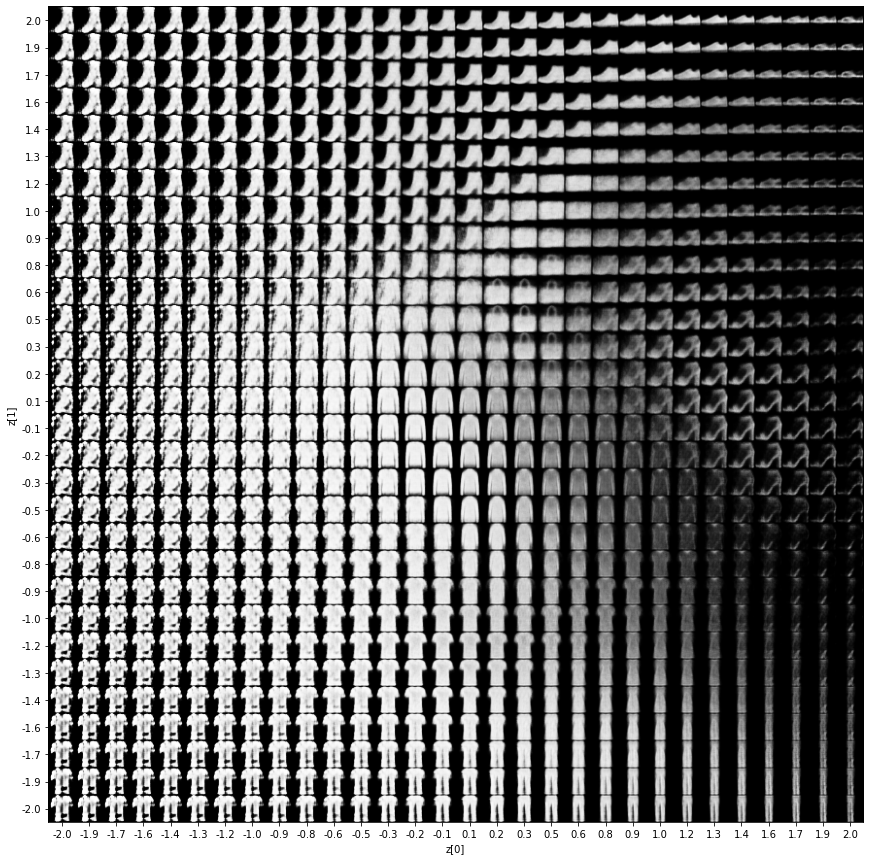

In [7]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of units
    n = 30
    unit_size = 28
    scale = 2.0 # диапазон пространства от минус 2 до 2
    figsize = 15
    figure = np.zeros((unit_size * n, unit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of unit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            unit = x_decoded[0].reshape(unit_size, unit_size)
            figure[
                i * unit_size : (i + 1) * unit_size,
                j * unit_size : (j + 1) * unit_size,
            ] = unit

    plt.figure(figsize=(figsize, figsize))
    start_range = unit_size // 2
    end_range = n * unit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, unit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(encoder, decoder)

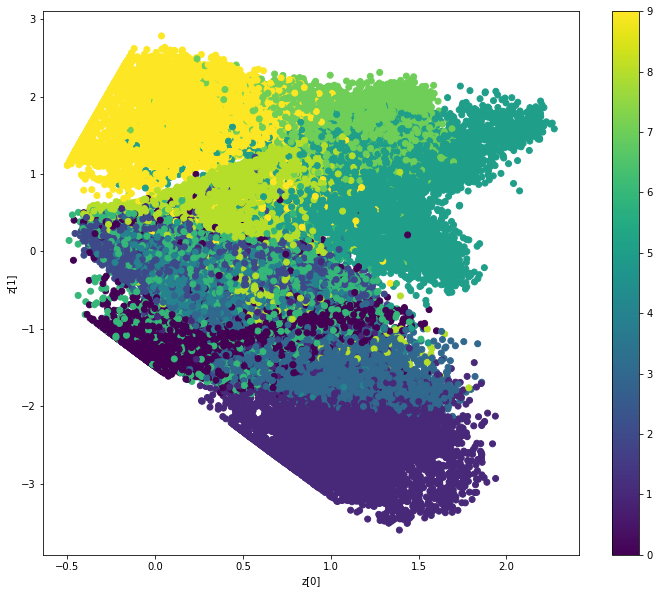

In [8]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the unit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

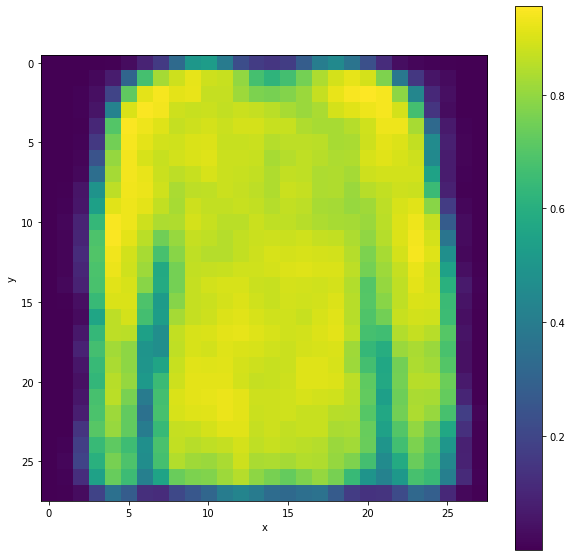

In [10]:
def plot_unit_from_decoder(decoder, z, unit_size):
    # display a 2D plot of the unit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    unit = decoder.predict(data)
    unit = unit.reshape(unit_size, unit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(unit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_unit_from_decoder(decoder, [-0.5,0.2], 28)

# **Microsoft Neural Network Algorithm**
Алгоритм нейронной сети Майкрософт — это реализация популярной и адаптируемой архитектуры нейронной сети для машинного обучения. Алгоритм работает путем тестирования каждого возможного состояния входного атрибута с каждым возможным состоянием прогнозируемого атрибута и использует обучающие данные для вычисления вероятностей каждого сочетания. Эти вероятности можно использовать для задач классификации или регрессии для прогнозирования результата на основе некоторых входных атрибутов. Нейронную сеть можно также использовать для анализа взаимосвязей.
Алгоритм нейронной сети Майкрософт полезен для анализа сложных входных данных, таких как из производственного или коммерческого процесса, или бизнес-задач, для которых доступно значительное количество обучающих данных, но для которых нельзя легко получить правила с помощью других алгоритмов.
Алгоритм нейронной сети Майкрософт создает сеть, состоящую из трех слоев узлов (иногда называемых нейронами). Такими слоями являются входной слой, скрытый слойи выходной слой.
Модель нейронной сети должна содержать ключевой столбец, один или несколько входных и прогнозируемых столбцов.

Нейронная сеть Майкрософт использует многослойную сеть Perceptron , также называемую сетью разностного правила обратного распространения, состоящей из трех слоев нейронов или перцептронов. Такими слоями являются входной слой, необязательный скрытый слой и выходной слой.

Особенности:
- Не поддерживается детализация и измерения интеллектуального анализа данных. Это объясняется тем, что структура узлов в модели интеллектуального анализа данных не обязательно однозначно соответствует базовым данным.

- Не поддерживается создание моделей в формате языка разметки прогнозирующих моделей (PMML).

- Поддерживается использование моделей интеллектуального анализа OLAP.

- Не поддерживается создание измерений интеллектуального анализа данных.


Несколько шагов участвуют в обучении модели интеллектуального анализа данных, которая использует алгоритм нейронной сети Майкрософт. На указанные шаги сильное влияние оказывают заданные значения параметров алгоритма.

Алгоритм сначала оценивает и извлекает обучающие данные из источника данных. Определенный процент обучающих данных, называемых контрольными данными, зарезервирован для использования при определении точности сети. В процессе обучения после каждой итерации по обучающим данным выполняется оценка сети. После прекращения роста точности модели процесс обучения завершается.
https://docs.microsoft.com/ru-ru/analysis-services/data-mining/microsoft-neural-network-algorithm-technical-reference?view=asallproducts-allversions